In [3]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import train_test_split
import shap
from imblearn.over_sampling import SMOTE
import random
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb


import random
from sklearn.model_selection import train_test_split
scoring="f1_macro"
smote  = SMOTEENN(random_state=4)
data = pd.read_csv('/content/end_result1.csv')


my_vocabulary={"thickening and narrowing of the small intestine":0,
              "thickening and narrowing of the colon":1,
              "rectal thickening and narrowing":2,
              "thickening and narrowing of the small intestine with expansion":3,
              "small intestinal fistula":4,
              "colon fistula":5,
              "anal fistula":6,
              "small bowel abscess":7,
              "rectal fistula":8,
              "thickening of the small intestine":9,
              "thickening and narrowing of the colon with expansion":10,
              "anal abscess":11,
              "colon abscess":12}
def replace_text(text):
    output_str = '"' + text.replace(',', '","').replace(' and ', ' ') + '"'
    return output_str
data["processed_text"] = data["text"].apply(replace_text)
vectorizer = TfidfVectorizer(vocabulary=my_vocabulary, ngram_range=(1,7))
text_features = vectorizer.fit_transform(data['text'].values.astype('U'))
fc_median = data ['FC'].median()
sex_median = data ['sex'].median()
year_old_median = data ['age'].median()
smoking_old_median = data ['smoking'].median()
education_median = data ['education'].median()
data['FC'].fillna(fc_median, inplace=True)
data['sex'].fillna(sex_median, inplace=True)
data['age'].fillna(year_old_median , inplace=True)
data['smoking'].fillna(smoking_old_median, inplace=True)
data['education'].fillna(education_median, inplace=True)

#All information
continuous_features = data[['CRP', "age"]].values.reshape(-1, 2)
categorical_features = data[["CDAI_score","SESCD_score","FC","sex","smoking","education"]].values.reshape(-1, 6)
continuous_features = continuous_features.astype(np.float64)
categorical_features = categorical_features.astype(np.float64)
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)
all_features = np.concatenate((text_features.toarray(), categorical_features, continuous_features), axis=1)
x=all_features
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
# LightGBM
lgb_param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    "random_state":[3]
}
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=3)
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, scoring=scoring, cv=5)
lgb_grid_search.fit(x, y)
lgb_scores = cross_val_score(lgb_grid_search, x, y, cv=5, scoring=scoring)
#SVM
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto'],"random_state":[3]}
svm_model =svm.SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring=scoring)
grid_search.fit(x, y)
svm_scores = cross_val_score(grid_search, x, y, cv=5, scoring=scoring)
#DT
dt_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 50, 100], 'min_samples_split': [2, 5, 10],"random_state":[3]}
dt_model = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring=scoring)
dt_grid_search.fit(x, y)
dt_scores = cross_val_score(dt_grid_search, x, y, cv=5, scoring=scoring)
# RF
rf_param_grid = {'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 50, 100], 'min_samples_split': [2, 5, 10],"random_state":[3]}
rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring=scoring)
rf_grid_search.fit(x, y)
rf_scores = cross_val_score(rf_grid_search, x, y, cv=5, scoring=scoring)
#XGBoost
XGBoost_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    "random_state":[3] }
xgb_model = xgb.XGBClassifier()
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=XGBoost_param_grid, scoring=scoring, cv=5)
xgb_grid_search.fit(x, y)
xgb_scores = cross_val_score(xgb_grid_search, x, y, cv=5, scoring=scoring)
print("all information")
print("Best parameters for lgb0: ", lgb_grid_search.best_params_)
print("Best score for lgb0: ", lgb_grid_search.best_score_)
print("scores for each fold: ", lgb_scores)
print("Best parameters for SVM0: ", grid_search.best_params_)
print("Best score for SVM0: ", grid_search.best_score_)
print("scores for each fold: ", svm_scores)
print("Best parameters for Decision Tree0: ", dt_grid_search.best_params_)
print("Best score for Decision Tree0: ", dt_grid_search.best_score_)
print("scores for each fold: ", dt_scores)
print("Best parameters for Random Forest0: ", rf_grid_search.best_params_)
print("Best score for Random Forest0: ", rf_grid_search.best_score_)
print("scores for each fold: ", rf_scores)
print("Best parameters for XGBoost_Random Forest0: ", xgb_grid_search.best_params_)
print("Best score for XGBoost_Random Forest0: ", xgb_grid_search.best_score_)
print("scores for each fold: ", xgb_scores)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
lgb_model=lgb.LGBMClassifier(num_leaves=31, max_depth=3, learning_rate=0.2, objective='multiclass', num_class=3, random_state=3)
svm_model=svm.SVC(C= 1, gamma= 'scale', kernel= 'linear', random_state= 3)
dt_model=DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=10, random_state=3)
rf_model=RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split= 2,random_state=3)
xgb_model=xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, random_state=3)

In [ ]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import train_test_split
import shap
from imblearn.over_sampling import SMOTE
import random
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb


import random
from sklearn.model_selection import train_test_split
scoring="f1_macro"
smote  = SMOTEENN(random_state=4)
data = pd.read_csv('/content/end_result1.csv')
my_vocabulary={"thickening and narrowing of the small intestine":0,
              "thickening and narrowing of the colon":1,
              "rectal thickening and narrowing":2,
              "thickening and narrowing of the small intestine with expansion":3,
              "small intestinal fistula":4,
              "colon fistula":5,
              "anal fistula":6,
              "small bowel abscess":7,
              "rectal fistula":8,
              "thickening of the small intestine":9,
              "thickening and narrowing of the colon with expansion":10,
              "anal abscess":11,
              "colon abscess":12}
def replace_text(text):
    output_str = '"' + text.replace(',', '","').replace(' and ', ' ') + '"'
    return output_str
data["processed_text"] = data["text"].apply(replace_text)
vectorizer = TfidfVectorizer(vocabulary=my_vocabulary, ngram_range=(1,7))
text_features = vectorizer.fit_transform(data['text'].values.astype('U'))
fc_median = data ['FC'].median()
sex_median = data ['sex'].median()
year_old_median = data ['age'].median()
smoking_old_median = data ['smoking'].median()
education_median = data ['education'].median()
data['FC'].fillna(fc_median, inplace=True)
data['sex'].fillna(sex_median, inplace=True)
data['age'].fillna(year_old_median , inplace=True)
data['smoking'].fillna(smoking_old_median, inplace=True)
data['education'].fillna(education_median, inplace=True)

#All information
continuous_features = data[['CRP', "age"]].values.reshape(-1, 2)
categorical_features = data[["CDAI_score","SESCD_score","FC","sex","smoking","education"]].values.reshape(-1, 6)
continuous_features = continuous_features.astype(np.float64)
categorical_features = categorical_features.astype(np.float64)
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)
all_features = np.concatenate((text_features.toarray(), categorical_features, continuous_features), axis=1)
x=all_features
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
# LightGBM
lgb_grid_search = lgb_model
lgb_grid_search.fit(x, y)
lgb_scores = cross_val_score(lgb_grid_search, x, y, cv=5, scoring=scoring)
#SVM
grid_search = svm_model
grid_search.fit(x, y)
svm_scores = cross_val_score(grid_search, x, y, cv=5, scoring=scoring)
#DT
dt_grid_search = dt_model
dt_grid_search.fit(x, y)
dt_scores = cross_val_score(dt_grid_search, x, y, cv=5, scoring=scoring)
#RF
rf_grid_search = rf_model
rf_grid_search.fit(x, y)
rf_scores = cross_val_score(rf_grid_search, x, y, cv=5, scoring=scoring)
#XGBoost
xgb_grid_search = xgb_model
xgb_grid_search.fit(x, y)
xgb_scores = cross_val_score(xgb_grid_search, x, y, cv=5, scoring=scoring)

#CDAI AND information of patient
continuous_features1 = data[["age"]].values.reshape(-1, 1)
categorical_features1 = data[["sex","CDAI_score","smoking","education"]].values.reshape(-1, 4)
continuous_features1 = continuous_features1.astype(np.float64)
categorical_features1 = categorical_features1.astype(np.float64)
scaler = StandardScaler()
continuous_features1 = scaler.fit_transform(continuous_features1)
all_features1 = np.concatenate((categorical_features1, continuous_features1), axis=1)
x=all_features1
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
# LightGBM
lgb_grid_search1 = lgb_model
lgb_grid_search1.fit(x, y)
lgb_scores1 = cross_val_score(lgb_grid_search1, x, y, cv=5, scoring=scoring)
#SVM
grid_search1 = svm_model
grid_search1.fit(x, y)
svm_scores1 = cross_val_score(grid_search1, x, y, cv=5, scoring=scoring)
#DT
dt_grid_search1 = dt_model
dt_grid_search1.fit(x, y)
dt_scores1 = cross_val_score(dt_grid_search1, x, y, cv=5, scoring=scoring)
#RF
rf_grid_search1 = rf_model
rf_grid_search1.fit(x, y)
rf_scores1 = cross_val_score(rf_grid_search1, x, y, cv=5, scoring=scoring)
#XGBoost
xgb_grid_search1 = xgb_model
xgb_grid_search1.fit(x, y)
xgb_scores1 = cross_val_score(xgb_grid_search1, x, y, cv=5, scoring=scoring)

#CDAI, CRP AND information of patient
continuous_features2 = data[['CRP', "age"]].values.reshape(-1, 2)
categorical_features2 = data[["CDAI_score","sex","smoking","education"]].values.reshape(-1, 4)
continuous_features2 = continuous_features2.astype(np.float64)
categorical_features2 = categorical_features2.astype(np.float64)
scaler = StandardScaler()
continuous_features2 = scaler.fit_transform(continuous_features2)
all_features2 = np.concatenate((categorical_features2, continuous_features2), axis=1)
x=all_features2
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
# LightGBM
lgb_grid_search2 = lgb_model
lgb_grid_search2.fit(x, y)
lgb_scores2 = cross_val_score(lgb_grid_search2, x, y, cv=5, scoring=scoring)
#SVM
grid_search2 = svm_model
grid_search2.fit(x, y)
svm_scores2 = cross_val_score(grid_search2, x, y, cv=5, scoring=scoring)
#DT
dt_grid_search2 = dt_model
dt_grid_search2.fit(x, y)
dt_scores2 = cross_val_score(dt_grid_search2, x, y, cv=5, scoring=scoring)
#RF
rf_grid_search2 = rf_model
rf_grid_search2.fit(x, y)
rf_scores2 = cross_val_score(rf_grid_search2, x, y, cv=5, scoring=scoring)
#XGBoost
xgb_grid_search2 = xgb_model
xgb_grid_search2.fit(x, y)
xgb_scores2 = cross_val_score(xgb_grid_search2, x, y, cv=5, scoring=scoring)

#CRP, CDAI ,SES-CD AND information of patient
continuous_features3 = data[['CRP', "age"]].values.reshape(-1, 2)
categorical_features3 = data[["CDAI_score","SESCD_score","sex","smoking","education"]].values.reshape(-1, 5)
continuous_features3 = continuous_features3.astype(np.float64)
categorical_features3 = categorical_features3.astype(np.float64)
scaler = StandardScaler()
continuous_features3 = scaler.fit_transform(continuous_features3)
all_features3 = np.concatenate((categorical_features3, continuous_features3), axis=1)
x=all_features3
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
#LightGBM
lgb_grid_search3 = lgb_model
lgb_grid_search3.fit(x, y)
lgb_scores3 = cross_val_score(lgb_grid_search3, x, y, cv=5, scoring=scoring)
#SVM
grid_search3 = svm_model
grid_search3.fit(x, y)
svm_scores3 = cross_val_score(grid_search3, x, y, cv=5, scoring=scoring)
#DT
dt_grid_search3 = dt_model
dt_grid_search3.fit(x, y)
dt_scores3 = cross_val_score(dt_grid_search3, x, y, cv=5, scoring=scoring)
#SVM
rf_grid_search3 = rf_model
rf_grid_search3.fit(x, y)
rf_scores3 = cross_val_score(rf_grid_search3, x, y, cv=5, scoring=scoring)
#XGBoost
xgb_grid_search3 = xgb_model
xgb_grid_search3.fit(x, y)
xgb_scores3 = cross_val_score(xgb_grid_search3, x, y, cv=5, scoring=scoring)

#CRP, CDAI, SES-CD ,CTE AND information of patient
continuous_features4 = data[['CRP', "age"]].values.reshape(-1, 2)
categorical_features4 = data[["CDAI_score","SESCD_score", "sex","smoking","education"]].values.reshape(-1, 5)
continuous_features4 = continuous_features4.astype(np.float64)
categorical_features4 = categorical_features4.astype(np.float64)
scaler = StandardScaler()
continuous_features4 = scaler.fit_transform(continuous_features4)
all_features4 = np.concatenate((text_features.toarray(), categorical_features4, continuous_features4), axis=1)
x=all_features4
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
#LightGBM
lgb_grid_search4 = lgb_model
lgb_grid_search4.fit(x, y)
lgb_scores4 = cross_val_score(lgb_grid_search4, x, y, cv=5, scoring=scoring)
#SVM
grid_search4 = svm_model
grid_search4.fit(x, y)
svm_scores4 = cross_val_score(grid_search4, x, y, cv=5, scoring=scoring)
#DT
dt_grid_search4 = dt_model
dt_grid_search4.fit(x, y)
dt_scores4 = cross_val_score(dt_grid_search4, x, y, cv=5, scoring=scoring)
#RF
rf_grid_search4 = rf_model
rf_grid_search4.fit(x, y)
rf_scores4 = cross_val_score(rf_grid_search4, x, y, cv=5, scoring=scoring)
#XGBoost
xgb_grid_search4 = xgb_model
xgb_grid_search4.fit(x, y)
xgb_scores4 = cross_val_score(xgb_grid_search4, x, y, cv=5, scoring=scoring)

#CRP, CDAI, SES-CD, FC AND information of patient
continuous_features5 = data[['CRP', "age"]].values.reshape(-1, 2)
categorical_features5 = data[["CDAI_score","SESCD_score","FC","sex","smoking","education"]].values.reshape(-1, 6)
continuous_features5 = continuous_features5.astype(np.float64)
categorical_features5 = categorical_features5.astype(np.float64)
scaler = StandardScaler()
continuous_features5 = scaler.fit_transform(continuous_features5)
all_features5 = np.concatenate((categorical_features5, continuous_features5), axis=1)
x=all_features5
y=data["label"]
# smote = SMOTEENN(random_state=random_state)
x, y= smote.fit_resample(x, y)
# LightGBM
lgb_grid_search5 = lgb_model
lgb_grid_search5.fit(x, y)
lgb_scores5 = cross_val_score(lgb_grid_search5, x, y, cv=5, scoring=scoring)
#SVM
grid_search5 = svm_model
grid_search5.fit(x, y)
svm_scores5 = cross_val_score(grid_search5, x, y, cv=5, scoring=scoring)
#DT
dt_grid_search5 = dt_model
dt_grid_search5.fit(x, y)
dt_scores5 = cross_val_score(dt_grid_search5, x, y, cv=5, scoring=scoring)
#RF
rf_grid_search5 = rf_model
rf_grid_search5.fit(x, y)
rf_scores5 = cross_val_score(rf_grid_search5, x, y, cv=5, scoring=scoring)
#XGBoost
xgb_grid_search5 = xgb_model
xgb_grid_search5.fit(x, y)
xgb_scores5 = cross_val_score(xgb_grid_search5, x, y, cv=5, scoring=scoring)


print("all information")
print("Best parameters for lgb0: ", lgb_scores)
print("Best score for lgb0: ", lgb_scores.mean())
print("Best parameters for SVM0: ", svm_scores)
print("Best score for SVM0: ", svm_scores.mean())
print("Best parameters for Decision Tree0: ", dt_scores)
print("Best score for Decision Tree0: ", dt_scores.mean())
print("Best parameters for Random Forest0: ", rf_scores)
print("Best score for Random Forest0: ", rf_scores.mean())
print("Best parameters for XGBoost_Random Forest0: ", xgb_scores)
print("Best score for XGBoost_Random Forest0: ", xgb_scores.mean())

print("CDAI AND information of patient")
print("Best parameters for lgb1: ", lgb_scores1)
print("Best score for lgb1: ", lgb_scores1.mean())
print("Best parameters for SVM1: ", svm_scores1)
print("Best score for SVM1: ", svm_scores1.mean())
print("Best parameters for Decision Tree1: ", dt_scores1)
print("Best score for Decision Tree1: ", dt_scores1.mean())
print("Best parameters for Random Forest1: ", rf_scores1)
print("Best score for Random Forest1: ", rf_scores1.mean())
print("Best parameters for XGBoost_Random Forest1: ", xgb_scores1)
print("Best score for XGBoost_Random Forest1: ", xgb_scores1.mean())

print("CRP, CDAI AND information of patient")
print("Best parameters for lgb2: ", lgb_scores1)
print("Best score for lgb2: ", lgb_scores2.mean())
print("Best parameters for SVM2: ", svm_scores2)
print("Best score for SVM2: ", svm_scores2.mean())
print("Best parameters for Decision Tree2: ", dt_scores2)
print("Best score for Decision Tree2: ", dt_scores2.mean())
print("Best parameters for Random Forest2: ", rf_scores2)
print("Best score for Random Forest2: ", rf_scores2.mean())
print("Best parameters for XGBoost_Random Forest0: ", xgb_scores2)
print("Best score for XGBoost_Random Forest2: ", xgb_scores2.mean())

print("CRP, CDAI, SES-CD AND information of patient")
print("Best parameters for lgb3: ", lgb_scores3)
print("Best score for lgb3: ", lgb_scores3.mean())
print("Best parameters for SVM3: ", svm_scores3)
print("Best score for SVM3: ", svm_scores3.mean())
print("Best parameters for Decision Tree3: ", dt_scores3)
print("Best score for Decision Tree3: ", dt_scores3.mean())
print("Best parameters for Random Forest3: ", rf_scores3)
print("Best score for Random Forest3: ", rf_scores3.mean())
print("Best parameters for XGBoost_Random Forest3: ", xgb_scores3)
print("Best score for XGBoost_Random Forest3: ", xgb_scores3.mean())

print("CRP, CDAI, SES-CD, CTE AND information of patient")
print("Best parameters for lgb4: ", lgb_scores4)
print("Best score for lgb4: ", lgb_scores4.mean())
print("Best parameters for SVM4: ", svm_scores4)
print("Best score for SVM4: ", svm_scores4.mean())
print("Best parameters for Decision Tree4: ", dt_scores4)
print("Best score for Decision Tree4: ", dt_scores4.mean())
print("Best parameters for Random Forest4: ", rf_scores4)
print("Best score for Random Forest4: ", rf_scores4.mean())
print("Best parameters for XGBoost_Random Forest4: ", xgb_scores4)
print("Best score for XGBoost_Random Forest4: ", xgb_scores4.mean())

print("CRP, CDAI, SES-CD, FC AND information of patient")
print("Best parameters for lgb5: ", lgb_scores5)
print("Best score for lgb5: ", lgb_scores5.mean())
print("Best parameters for SVM5: ", svm_scores5)
print("Best score for SVM5: ", svm_scores5.mean())
print("Best parameters for Decision Tree5: ", dt_scores5)
print("Best score for Decision Tree5: ", dt_scores5.mean())
print("Best parameters for Random Forest5: ", rf_scores5)
print("Best score for Random Forest5: ", rf_scores5.mean())
print("Best parameters for XGBoost_Random Forest5: ", xgb_scores5)
print("Best score for XGBoost_Random Forest5: ", xgb_scores5.mean())


流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

  0%|          | 0/106 [00:00<?, ?it/s]

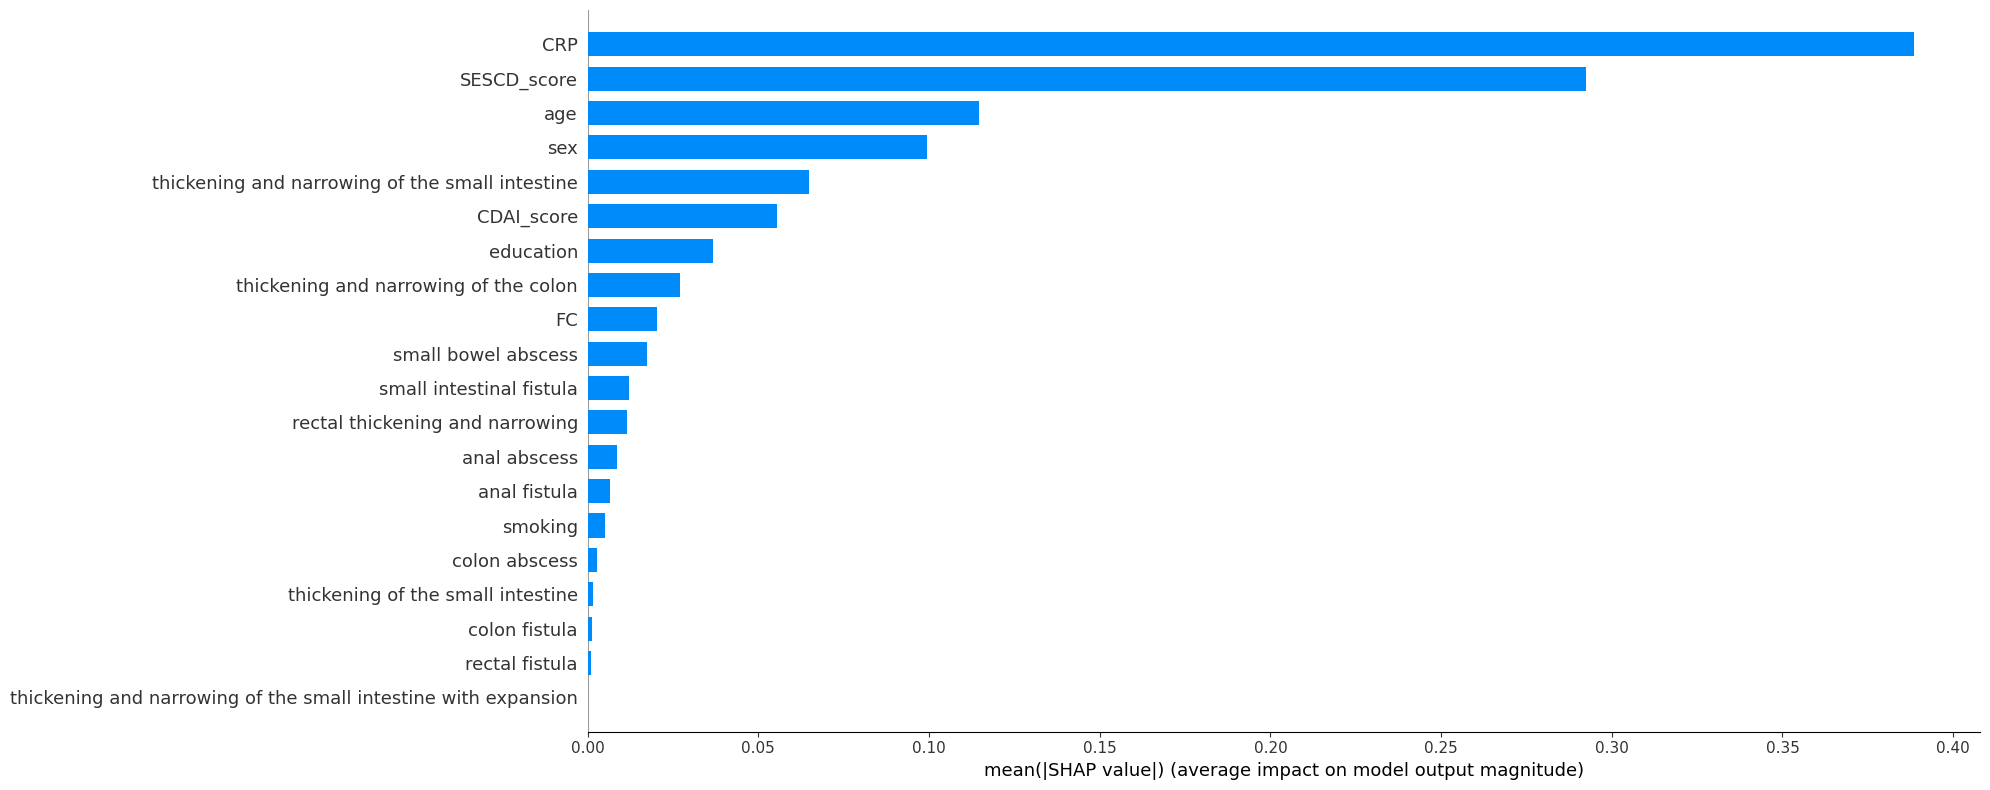

In [8]:
feature_names = ["thickening and narrowing of the small intestine",
              "thickening and narrowing of the colon",
              "rectal thickening and narrowing",
              "thickening and narrowing of the small intestine with expansion",
              "small intestinal fistula",
              "colon fistula",
              "anal fistula",
              "small bowel abscess",
              "rectal fistula",
              "thickening of the small intestine",
              "thickening and narrowing of the colon with expansion",
              "anal abscess",
              "colon abscess",'CDAI_score', 'SESCD_score', 'FC', "sex","smoking","education",'CRP', 'age']
from shap.plots import _waterfall
explainer = shap.KernelExplainer(model=grid_search.predict,data=all_features)
shap_values = explainer.shap_values(all_features, feature_names=feature_names)
shap.summary_plot(shap_values, all_features, plot_type="bar",feature_names=feature_names,plot_size=(20, 8),show=False)
plt.savefig("summary_plot.png", dpi=600, bbox_inches="tight", facecolor='white')

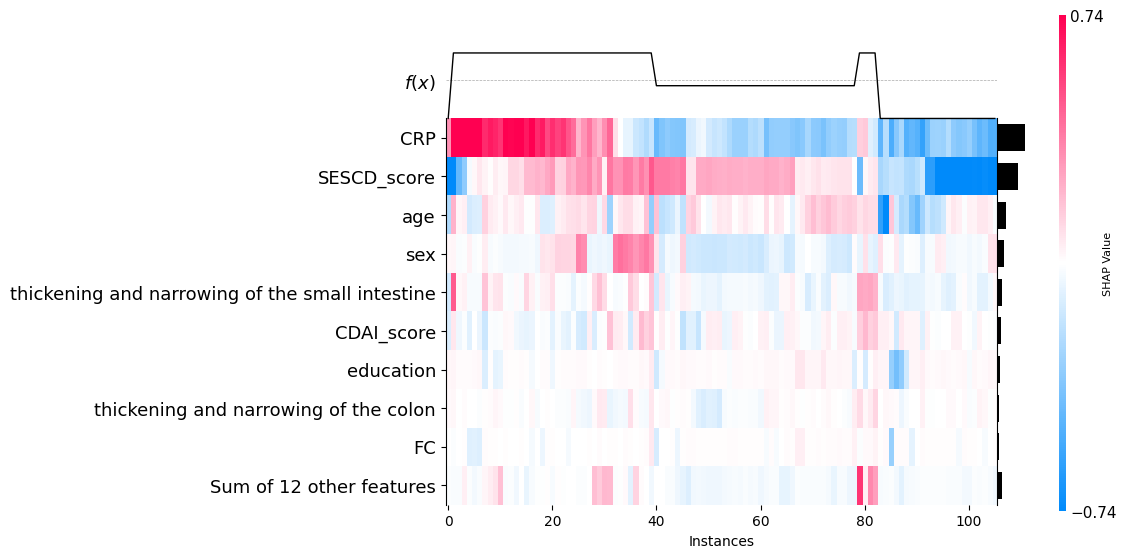

In [7]:
shap_values = shap.Explanation(shap_values, feature_names=feature_names)
shap.plots.heatmap(shap_values,show=False)
cax = plt.gcf().axes[-1]
cax.set_ylabel("SHAP Value",fontsize=8)
plt.savefig("svmplot2.jpg", dpi=600, bbox_inches="tight", facecolor='white')

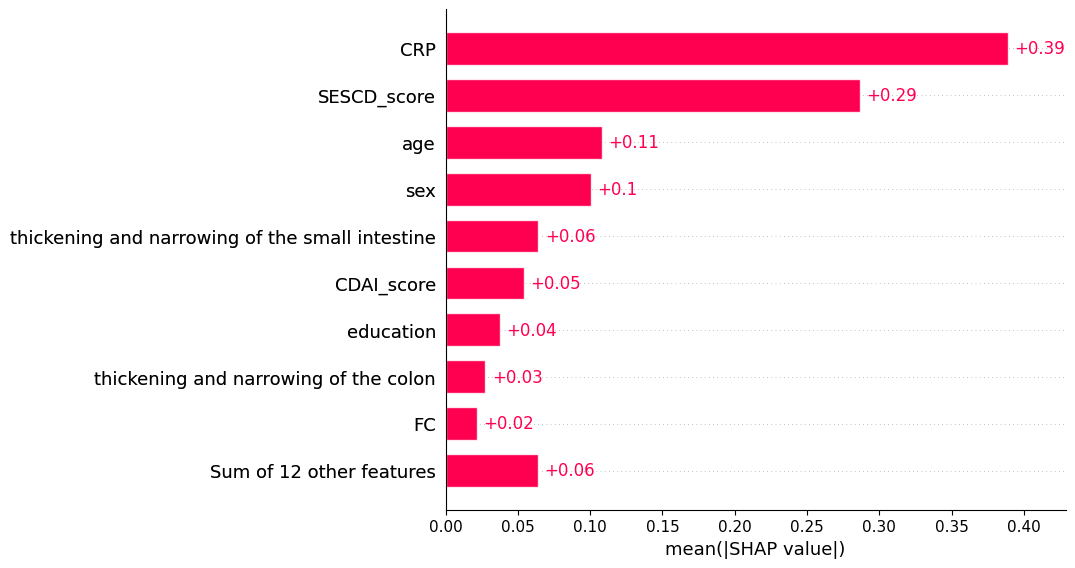

In [ ]:
feature_names = ["thickening and narrowing of the small intestine",
              "thickening and narrowing of the colon",
              "rectal thickening and narrowing",
              "thickening and narrowing of the small intestine with expansion",
              "small intestinal fistula",
              "colon fistula",
              "anal fistula",
              "small bowel abscess",
              "rectal fistula",
              "thickening of the small intestine",
              "thickening and narrowing of the colon with expansion",
              "anal abscess",
              "colon abscess",'CDAI_score', 'SESCD_score', 'FC', "sex","smoking","education",'CRP', 'age']
import shap
explainer = shap.Explainer(grid_search.predict, all_features, feature_names=feature_names)
shap_values=explainer(all_features)
shap.plots.bar(shap_values, show=False)
plt.savefig("xgbblot.jpg", dpi=600, bbox_inches="tight", facecolor='white')

In [9]:
import seaborn as sns
shap.initjs()
# 生成force_plot的输出并保存为HTML文件
shap.force_plot(explainer.expected_value, shap_values, all_features, feature_names=feature_names)

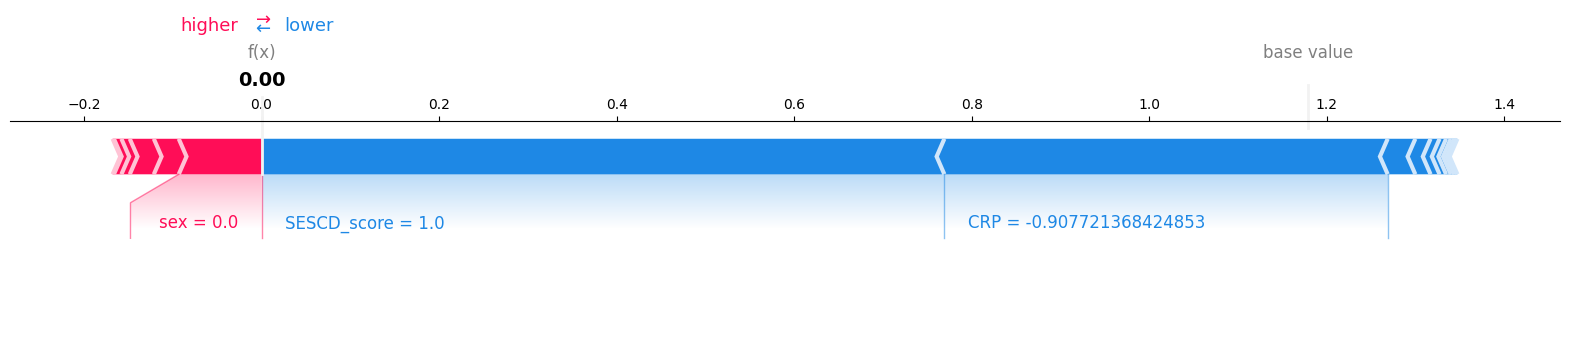

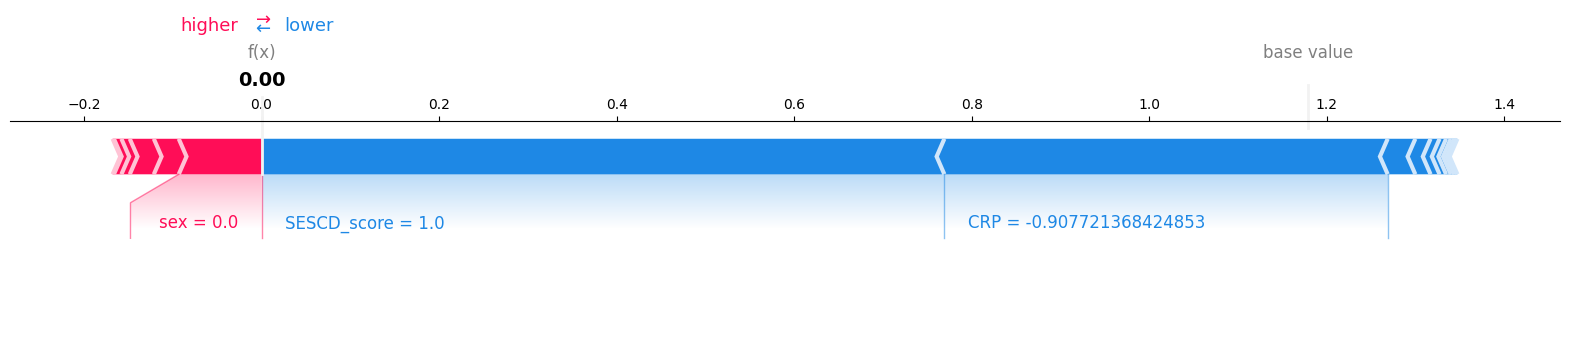

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], all_features[0], feature_names=feature_names, matplotlib=True)